In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cycler import cycler
import sys
import os
from matplotlib2tikz import save as tikz_save
import numpy as np
from numpy import pi
from glob import glob
import h5py

%matplotlib inline
color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
mpl.rc('figure',figsize=[10,6])
mpl.rc('font',size=15.0)
#mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rc('lines',linewidth=1.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=1.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=1.3,linestyle=':')
mpl.rc('legend',fontsize='medium',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)



In [2]:
location = 'history' # which history directory
addendum = ''

fileAV2 = '{0}/BoundaryAVExcitation{1}-magEddyCurrent2-surfRegion-S_sigma_plus.hist'.format(location, addendum) # amplitude phase
#fileA = '{0}/simpleCoilCyl_A-magEddyCurrent-surfRegion-S_sigma_minus.hist'.format(location, addendum)
fileAV1 = '{0}/BoundaryAVExcitation{1}-magEddyCurrent1-surfRegion-S_sigma_plus.hist'.format(location, addendum) # real imaginary

realAVstring = np.asarray( [x.split(' ')[2] for x in open(fileAV1).readlines()[3:]])
imagAVstring =np.asarray( [x.split(' ')[4] for x in open(fileAV1).readlines()[3:]])
realAV = realAVstring.astype(np.float)
imagAV = imagAVstring.astype(np.float)

freqAVstring = np.asarray( [x.split(' ')[0] for x in open(fileAV2).readlines()[3:]])
amplitudeAVstring = np.asarray( [x.split(' ')[2] for x in open(fileAV2).readlines()[3:]])
phaseAVstring =np.asarray( [x.split(' ')[4] for x in open(fileAV2).readlines()[3:]])
amplitudeAV = amplitudeAVstring.astype(np.float)
phaseAV = phaseAVstring.astype(np.float)

f = freqAVstring.astype(np.float)

#amplitudeAstring = np.asarray( [x.split(' ')[2] for x in open(fileA).readlines()[3:]])
#phaseAstring =np.asarray( [x.split(' ')[4] for x in open(fileA).readlines()[3:]])

#amplitudeA = amplitudeAstring.astype(np.float)
#phaseA = phaseAstring.astype(np.float)

print(f)

[  1.00000000e+00   2.64105000e+02   5.27211000e+02   7.90316000e+02
   1.05342000e+03   1.31653000e+03   1.57963000e+03   1.84274000e+03
   2.10584000e+03   2.36895000e+03   2.63205000e+03   2.89516000e+03
   3.15826000e+03   3.42137000e+03   3.68447000e+03   3.94758000e+03
   4.21068000e+03   4.47379000e+03   4.73689000e+03   5.00000000e+03]


In [3]:
r = 0.001 # radius of cylindrical conductor in m
l = 1 # length of conductor in m
mu_0 = 4*np.pi*1e-7 # vacuum permeability in H/m
mur=1 # relative permeability in H/m
mu = mu_0 * mur
sigma = 5.67e7 # conductivity in 1/(Ohm*m)
rho = 1/sigma # resistivity in Ohm*m
d = 2*r

In [4]:
"""
Complex AC circuit: U=Z*I, with Z=j*omega*L
"""
#f = np.linspace(1,1e4,100) #Hz
#f=1e2
omega = 2*np.pi*f
m = np.sqrt(omega*mu*sigma)

In [5]:
import scipy.special as sp

"""
Z is in Ohm/m !!!
"""
z = (1j*m*rho) / (2*np.pi*r) * \
    (sp.ber(m*r) + 1j*sp.bei(m*r)) / (sp.berp(m*r) + 1j*sp.beip(m*r))


In [6]:
# Rdc is the DC resistance of the conductor in Ohm/m
Rdc = rho/(r**2*np.pi)
R_over_Rdc = m*r/2 * (sp.ber(m*r)*sp.beip(m*r) - sp.bei(m*r)*sp.berp(m*r))/ (sp.berp(m*r)**2 + sp.beip(m*r)**2)


# Lidc is the internal DC inductance of the conductor in H/m
# Lidc=mu/(8*pi)
L_over_Lidc = 4/(m*r) * (sp.ber(m*r)*sp.berp(m*r) + sp.bei(m*r)*sp.beip(m*r))/ (sp.berp(m*r)**2 + sp.beip(m*r)**2)


In [7]:
# external inductance of the surrounding insulating material (air)
L_e = mu_0/(2*np.pi) * (np.log(4*l/d) - 1)

#the https://www.emisoftware.com/calculator/inductance-wire-external/
#uses a more complicated formula, check it out
L_e_emi = l*mu_0/(2*np.pi)*(np.arcsinh(l/r) - np.sqrt(1+(r/l)**2) + r/l)

# overall induciton
L = (z.imag/omega) * l + L_e

# the resistance values coincides with the one from emi:
# https://www.emisoftware.com/calculator/resistance-circular-wire/

Z = z.real * l + 1j*omega*L

u = 1 + 0j
i=u/Z


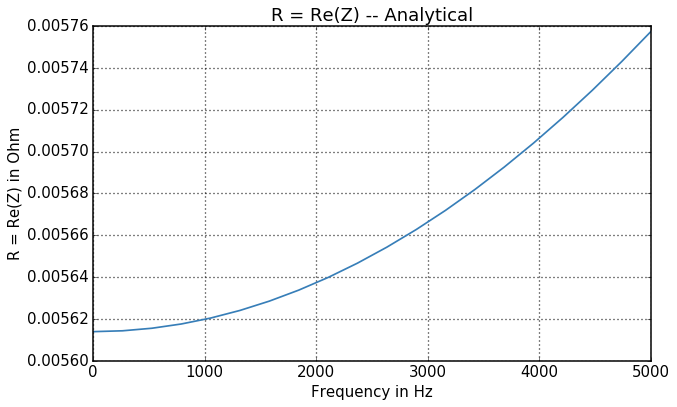

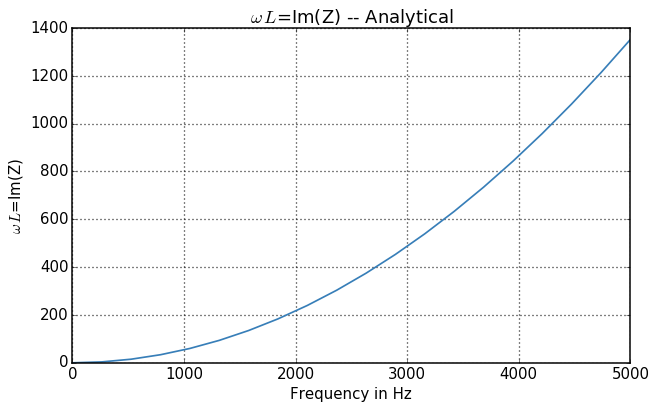

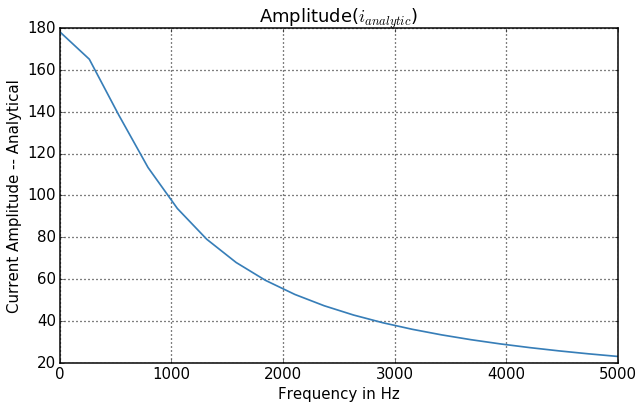

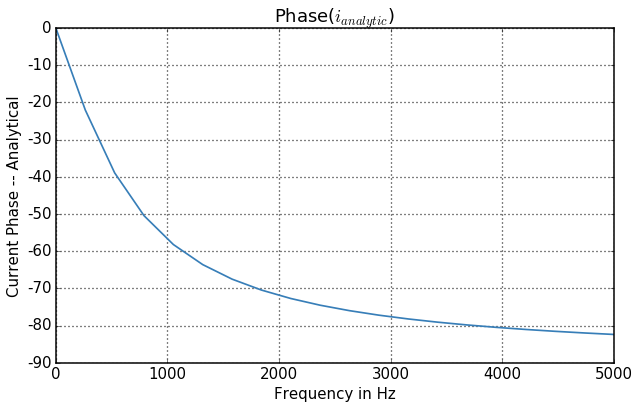

In [8]:
import cmath
phase = np.zeros(i.size)
for k in range(i.size):
    phase[k] = cmath.phase(i[k])   

xlim = np.max(f)
    
fig,ax=plt.subplots()
ax.plot(f, Z.real)
ax.set_xlim([0,xlim])
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('R = Re(Z) in Ohm')
ax.set_title('R = Re(Z) -- Analytical')

fig,ax=plt.subplots()
ax.plot(f, omega*Z.imag)
ax.set_xlim([0,xlim])
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('$\omega\, L$=Im(Z)')
ax.set_title('$\omega\, L$=Im(Z) -- Analytical')


fig,ax=plt.subplots()
ax.plot(f, abs(i))
ax.set_xlim([0,xlim])
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current Amplitude -- Analytical')
ax.set_title('Amplitude($i_{analytic}$)')

fig,ax=plt.subplots()
ax.plot(f, phase*360/(2*np.pi))
ax.set_xlim([0,xlim])
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current Phase -- Analytical')
ax.set_title('Phase($i_{analytic}$)')


In [9]:
if len(i) is 1:
    print('amplitude i='+str(abs(i)))
    print('phase i='+str(cmath.phase(i)))
    print('Z = '+ str(Z))
print('length of i is '+ str(len(i)))


length of i is 20


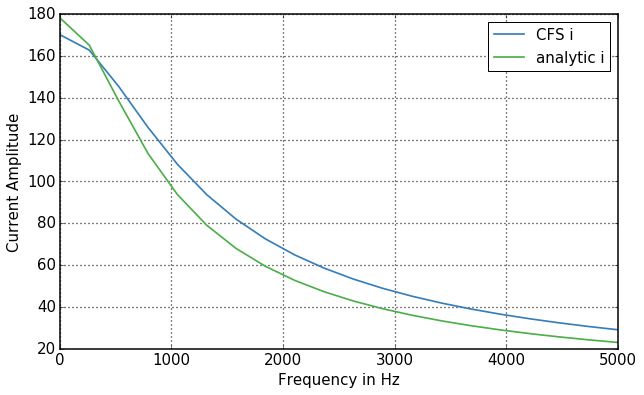

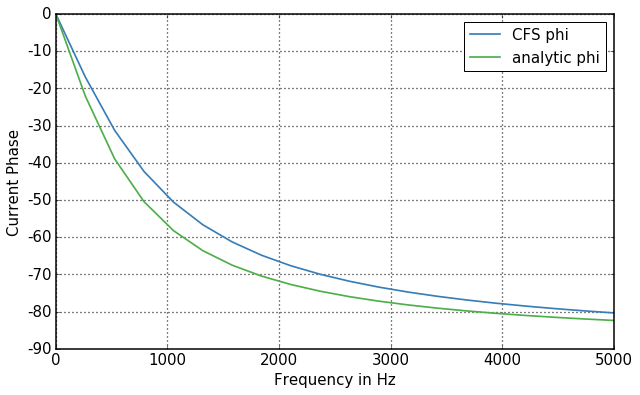

In [10]:
fig,ax=plt.subplots()
ax.plot(f, amplitudeAV,label='CFS i')
ax.hold(True)
ax.plot(f, abs(i),label='analytic i')
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current Amplitude')
ax.legend()
#tikz_save('amplitude.tex')

fig,ax=plt.subplots()
ax.plot(f, phaseAV,label='CFS phi')
ax.hold(True)
ax.plot(f, phase*360/(2*np.pi),label='analytic phi')
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current Phase')
ax.legend()
#tikz_save('phase.tex')

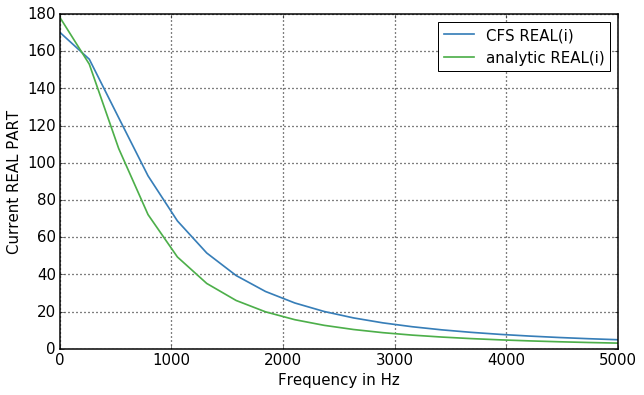

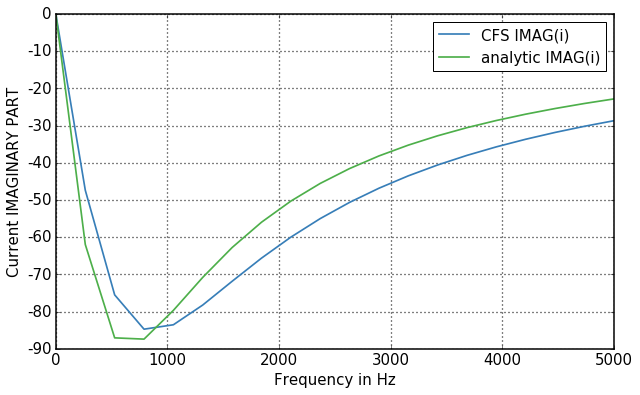

In [11]:
fig,ax=plt.subplots()
ax.plot(f, realAV,label='CFS REAL(i)')
ax.hold(True)
ax.plot(f, i.real,label='analytic REAL(i)')
#ax.set_xlim([0,500000])
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current REAL PART')
ax.legend()
#tikz_save('real.tex')

fig,ax=plt.subplots()
ax.plot(f, imagAV,label='CFS IMAG(i)')
ax.hold(True)
ax.plot(f, i.imag,label='analytic IMAG(i)')
ax.set_xlabel('Frequency in Hz')
ax.set_ylabel('Current IMAGINARY PART')
ax.legend()
#tikz_save('imag.tex')